## Mesh Generation and Input Files Preparation for SeisSol
### D. Li, 30 Dec 2023


In [1]:
# load modules required
import numpy as np
import matplotlib.pyplot as plt
# from netCDF4 import Dataset

import netCDF4
import pyproj

print('modules loaded!')
# from mpl_toolkits.basemap import Basemap

# 2. generate GMSH file.

In [2]:
# # define a tag function for M print(xgrid, ygrid)
# def tag(i, j):
#     return (N + 1) * i + j + 1

In [24]:
# load data and covnert to Cartesian coords (need to define the code for proj. )

def load_netcdf_file(nc_file):
    nc_data = netCDF4.Dataset(nc_file)
    
    longitude = nc_data.variables["lon"][:]
    latitude = nc_data.variables["lat"][:]
    elevation = nc_data.variables["z"][:,:]
    # print(nc_data)
    
    # convert surface topographic data into Cartesian coordinates
    
    samples = len(longitude)
    
    min_latitude= min(latitude)
    min_latitude= min(latitude)
    min_longitude= min(longitude)
    
    max_latitude= max(latitude)
    max_longitude= max(longitude)
    
    # average over neighbours if necessary
    # mark_x = np.where( topo == -32768 )[0]
    # mark_y = np.where( topo == -32768 )[1]
    # for x, y in zip(mark_x, mark_y) :
    #     slice = topo[max(0, x-1):x+1, max(0,y-1):y+1] # assuming a 5x5 square
    #     topo[x,y] = np.mean([i for i in slice.flatten() if i > 0])  # threshold is 0
    
    x_lon = np.linspace((min_longitude),(max_longitude),samples)
    y_lat = np.linspace((min_latitude),(max_latitude),samples)
    
    # UTM projection for NZTM2000
    
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    myproj = pyproj.Proj(init='epsg:2193', datum='WGS84')
    
    xyz_map = pyproj.transform(lla, myproj, x_lon,y_lat, np.zeros(len(x_lon)), radians=False)
    xgrid = xyz_map[0]
    ygrid = xyz_map[1]

    return xgrid, ygrid,elevation


In [40]:
# User define:
# chosse if you need Velocity-aware mesh
# define the 

# example: 1D equally-spaced Vs model (unit: m/s)

vs = np.linspace(2885,3800,20)
z = np.linspace(-20e3,100.0,20)

# default max. mesh size
lc = 2e3
fre_high = 1.
num_elements_per_wavelength = 2.

In [41]:
# define adaptive mesh refinement scheme

def cal_mesh_lc(x0,y0,z0):
    
    if z0 > 0:
        lc =  500.0 # Densify the mesh for buildings
    else:
        ind_z = (np.abs(z0-z)).argmin()
        lc = vs[ind_z] / fre_high / num_elements_per_wavelength
    return lc

def cal_mesh_size(entity_dim, entity_tag, x, y, z, lc):
    return cal_mesh_lc(x,y,z) 

In [25]:
# User define:
# load topographic data for the research domain
# Load NetCDF file for topographic data 

nc_file = '/Users/duoli/Documents/NSHM_SRM/Geometry/NZ_gebco_03s.grd'  # Replace with your actual file path
xgrid, ygrid,elevation = load_netcdf_file(nc_file)
print(xgrid.size, elevation.shape)


246 (246, 246)


/Users/duoli/anaconda3/envs/py39/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/w1/_6wbwxqn58j2p6t9v4n73wcr0000gn/T/ipykernel_27677/2871728860.py:37: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xyz_map = pyproj.transform(lla, myproj, x_lon,y_lat, np.zeros(len(x_lon)), radians=False)


In [9]:

# to add topographic data in Model geometry

xmin = xgrid[0] # Unit (m)
xmax = xgrid[-1]
ymin = ygrid[0]
ymax = ygrid[-1]
zmax = -15000. # bottom surface

# Create the terrain mesh with N by N data points 
# (Make sure the spatial resolution matching topographic data):
N = 300

# Helper function to return a node tag given two indices i and j:
def tag(i, j):
    return (N + 1) * i + j + 1

# The x, y, z coordinates of all the nodes:
coords = []

# The tags of the corresponding nodes:
nodes = []

# The connectivities of the triangle elements (3 node tags per triangle) on the
# terrain surface:
tris = []

# The connectivities of the line elements on the 4 boundaries (2 node tags
# for each line element):
lin = [[], [], [], []]

# The connectivities of the point elements on the 4 corners (1 node tag for each
# point element):
pnt = [tag(0, 0), tag(N, 0), tag(N, N), tag(0, N)]

# Adding topography point by point
x_grid = np.linspace(xmin,xmax,N+1)
y_grid = np.linspace(ymin,ymax,N+1)

print(xmin,xmax,ymin,ymax)

1742107.414627544 1759672.350692968 5415443.196236902 5437755.326004376


In [42]:
# Initialize GMSH
import gmsh

def generate_mesh(MeshFile,xgrid, ygrid, topo, N,bottom_depth):

    xmin = xgrid[0] # Unit (m)
    xmax = xgrid[-1]
    ymin = ygrid[0]
    ymax = ygrid[-1]
    zmax = bottom_depth # bottom surface
    
    # Create the terrain mesh with N by N data points 
    # (Make sure the spatial resolution matching topographic data):
    
    # Helper function to return a node tag given two indices i and j:
    def tag(i, j):
        return (N + 1) * i + j + 1
    
    # The x, y, z coordinates of all the nodes:
    coords = []
    
    # The tags of the corresponding nodes:
    nodes = []
    
    # The connectivities of the triangle elements (3 node tags per triangle) on the
    # terrain surface:
    tris = []
    
    # The connectivities of the line elements on the 4 boundaries (2 node tags
    # for each line element):
    lin = [[], [], [], []]
    
    # The connectivities of the point elements on the 4 corners (1 node tag for each
    # point element):
    pnt = [tag(0, 0), tag(N, 0), tag(N, N), tag(0, N)]
    
    # Adding topography point by point
    x_grid = np.linspace(xmin,xmax,N+1)
    y_grid = np.linspace(ymin,ymax,N+1)
    
    print(xmin,xmax,ymin,ymax)
    
    gmsh.initialize()
    gmsh.model.add('MeshAdaptiveVel')
    
    
    for i in range(N + 1):
        for j in range(N + 1):
            nodes.append(tag(i, j))
            ind_x = (np.abs(x_grid[i]-xgrid)).argmin() # find the X index of nearest point in topo matrix
            ind_y = (np.abs(y_grid[j]-ygrid)).argmin() # find the Y index of nearest point in topo matrix
            coords.extend([x_grid[i],y_grid[j],np.float64(topo[ind_y,ind_x])]) # Add the elevation 
            if i > 0 and j > 0:
                tris.extend([tag(i - 1, j - 1), tag(i, j - 1), tag(i - 1, j)]) 
                tris.extend([tag(i, j - 1), tag(i, j), tag(i - 1, j)])
            if (i == 0 or i == N) and j > 0:
                lin[3 if i == 0 else 1].extend([tag(i, j - 1), tag(i, j)])
            if (j == 0 or j == N) and i > 0:
                lin[0 if j == 0 else 2].extend([tag(i - 1, j), tag(i, j)])
    
    # Create 4 discrete points for the 4 corners of the terrain surface:
    for i in range(4):
        gmsh.model.addDiscreteEntity(0, i + 1)
    gmsh.model.setCoordinates(1, xmin, ymin, coords[3 * tag(0, 0) - 1])
    gmsh.model.setCoordinates(2, xmax, ymin, coords[3 * tag(N, 0) - 1])
    gmsh.model.setCoordinates(3, xmax, ymax, coords[3 * tag(N, N) - 1])
    gmsh.model.setCoordinates(4, xmin, ymax, coords[3 * tag(0, N) - 1])
    
    # Create 4 discrete bounding curves, with their boundary points:
    for i in range(4):
        gmsh.model.addDiscreteEntity(1, i + 1, [i + 1, i + 2 if i < 3 else 1])
    
    # Create one discrete surface, with its bounding curves:
    gmsh.model.addDiscreteEntity(2, 1, [1, 2, -3, -4])
    
    # Add all the nodes on the surface:
    gmsh.model.mesh.addNodes(2, 1, nodes, coords)
    gmsh.model.addPhysicalGroup(2, [1], 101) # Free-surface boundary label
    
    # Add point elements on the 4 points, line elements on the 4 curves, and triangle elements on the surface:
    for i in range(4):
        # Type 15 for point elements:
        gmsh.model.mesh.addElementsByType(i + 1, 15, [], [pnt[i]])
        # Type 1 for 2-node line elements:
        gmsh.model.mesh.addElementsByType(i + 1, 1, [], lin[i])
    # Type 2 for 3-node triangle elements:
    gmsh.model.mesh.addElementsByType(1, 2, [], tris)
    
    # Reclassify the nodes on the curves and the points 
    gmsh.model.mesh.reclassifyNodes()
    
    # Create a geometry for the discrete curves and surfaces, so that we can remesh them later on:
    gmsh.model.mesh.createGeometry()
    
    # Create other entities to form one volume below the terrain surface:
    p1 = gmsh.model.geo.addPoint(xmin, ymin, zmax)
    p2 = gmsh.model.geo.addPoint(xmax, ymin, zmax)
    p3 = gmsh.model.geo.addPoint(xmax, ymax, zmax)
    p4 = gmsh.model.geo.addPoint(xmin, ymax, zmax)
    c1 = gmsh.model.geo.addLine(p1, p2)
    c2 = gmsh.model.geo.addLine(p2, p3)
    c3 = gmsh.model.geo.addLine(p3, p4)
    c4 = gmsh.model.geo.addLine(p4, p1)
    c10 = gmsh.model.geo.addLine(p1, 1)
    c11 = gmsh.model.geo.addLine(p2, 2)
    c12 = gmsh.model.geo.addLine(p3, 3)
    c13 = gmsh.model.geo.addLine(p4, 4)
    ll1 = gmsh.model.geo.addCurveLoop([c1, c2, c3, c4]) 
    s1 = gmsh.model.geo.addPlaneSurface([ll1]) # bot
    ll3 = gmsh.model.geo.addCurveLoop([c1, c11, -1, -c10]) # fro
    s3 = gmsh.model.geo.addPlaneSurface([ll3]) # fro
    ll4 = gmsh.model.geo.addCurveLoop([c2, c12, -2, -c11])
    s4 = gmsh.model.geo.addPlaneSurface([ll4]) # rig
    ll5 = gmsh.model.geo.addCurveLoop([c3, c13, 3, -c12])
    s5 = gmsh.model.geo.addPlaneSurface([ll5]) # bac 
    ll6 = gmsh.model.geo.addCurveLoop([c4, c10, 4, -c13])
    s6 = gmsh.model.geo.addPlaneSurface([ll6]) # lef
    
    
    gmsh.model.geo.synchronize()  # must add synchronize before addPhysicalGroup
    gmsh.model.addPhysicalGroup(2, [s1, s3, s4, s5, s6], 105)  # Absorbing boundary label
    sl1 = gmsh.model.geo.addSurfaceLoop([s1, s3, s4, s5, s6, 1])
    v1 = gmsh.model.geo.addVolume([sl1])
    
    gmsh.model.geo.synchronize()
    gmsh.model.addPhysicalGroup(3, [v1], 1)
    gmsh.model.geo.synchronize()
    
    # gmsh.model.mesh.field.setAsBackgroundMesh(7)
    gmsh.model.occ.synchronize()
    
    gmsh.model.mesh.setSizeCallback(cal_mesh_size)
    
    gmsh.model.mesh.generate(3)
    
    gmsh.write( MeshFile +'.msh2') # type 2 Gmsh file  
    
    
    gmsh.finalize()

In [ ]:
MeshFile = "WelBasin_1zh_adaptive" # define the output mesh file name
N  = 400 # surface sample rate
bottom_depth = -15000.0 # bottom surface in meter

generate_mesh(MeshFile, xgrid, ygrid, elevation,N,bottom_depth)

1742107.414627544 1759672.350692968 5415443.196236902 5437755.326004376
Info    : Increasing process stack size (8192 kB < 16 MB)
Info    : Creating geometry of discrete curves...
Info    : Done creating geometry of discrete curves (Wall 0.000152121s, CPU 0.000164s)
Info    : Creating geometry of discrete surfaces...


Exception ignored on calling ctypes callback function: <function model.mesh.setSizeCallback.<locals>.<lambda> at 0x115831dc0>
Traceback (most recent call last):
  File "/Users/duoli/anaconda3/envs/py39/lib/python3.9/site-packages/gmsh.py", line 3973, in <lambda>
    api_callback_ = api_callback_type_(lambda dim, tag, x, y, z, lc, _ : callback(dim, tag, x, y, z, lc))
  File "/var/folders/w1/_6wbwxqn58j2p6t9v4n73wcr0000gn/T/ipykernel_27677/3629647730.py", line 13, in cal_mesh_size
  File "/var/folders/w1/_6wbwxqn58j2p6t9v4n73wcr0000gn/T/ipykernel_27677/3629647730.py", line 8, in cal_mesh_lc
NameError: name 'z' is not defined
Exception ignored on calling ctypes callback function: <function model.mesh.setSizeCallback.<locals>.<lambda> at 0x115831dc0>
Traceback (most recent call last):
  File "/Users/duoli/anaconda3/envs/py39/lib/python3.9/site-packages/gmsh.py", line 3973, in <lambda>
    api_callback_ = api_callback_type_(lambda dim, tag, x, y, z, lc, _ : callback(dim, tag, x, y, z, lc))


Info    : Done creating geometry of discrete surfaces (Wall 4.72491s, CPU 3.93624s)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Discrete curve)


Exception ignored on calling ctypes callback function: <function model.mesh.setSizeCallback.<locals>.<lambda> at 0x115831dc0>
Traceback (most recent call last):
  File "/Users/duoli/anaconda3/envs/py39/lib/python3.9/site-packages/gmsh.py", line 3973, in <lambda>
    api_callback_ = api_callback_type_(lambda dim, tag, x, y, z, lc, _ : callback(dim, tag, x, y, z, lc))
  File "/var/folders/w1/_6wbwxqn58j2p6t9v4n73wcr0000gn/T/ipykernel_27677/3629647730.py", line 13, in cal_mesh_size
  File "/var/folders/w1/_6wbwxqn58j2p6t9v4n73wcr0000gn/T/ipykernel_27677/3629647730.py", line 8, in cal_mesh_lc
NameError: name 'z' is not defined
Exception ignored on calling ctypes callback function: <function model.mesh.setSizeCallback.<locals>.<lambda> at 0x115831dc0>
Traceback (most recent call last):
  File "/Users/duoli/anaconda3/envs/py39/lib/python3.9/site-packages/gmsh.py", line 3973, in <lambda>
    api_callback_ = api_callback_type_(lambda dim, tag, x, y, z, lc, _ : callback(dim, tag, x, y, z, lc))


In [37]:
# generate a xdmf file for Paraview
import meshio

# Load the .msh file
def convert_mesh(MeshFile):
    
    mesh = meshio.read(
    MeshFile+ '.msh2',  # string, os.PathLike, or a buffer/open file
    file_format="gmsh",  # optional if filename is a path; inferred from extension
    )

    meshio.write(
    MeshFile+".vtk",  # str, os.PathLike, or buffer/ open file
    mesh,
    file_format="vtk",  # optional if first argument is a path; inferred from extension
    )
    

In [38]:
# User define: name of the mesh file msh2
# convert the Mesh File msh2 to VTK for Paraview

convert_mesh(MeshFile)

# 2. load data and plot

In [2]:
def plot_surface_rupture_intensity(nc_file_path):
    # Open the NetCDF file
    nc_file = Dataset(nc_file_path, 'r')

    # Assuming you have variables for latitude, longitude, and surface rupture intensity
    latitude = nc_file.variables['latitude'][:]
    longitude = nc_file.variables['longitude'][:]
    rupture_intensity = nc_file.variables['surface_rupture_intensity'][:]

    # Close the NetCDF file
    nc_file.close()

    # Create a meshgrid for plotting
    lon, lat = np.meshgrid(longitude, latitude)

    # Plot the surface rupture intensity
    plt.figure(figsize=(10, 8))
    plt.contourf(lon, lat, rupture_intensity, cmap='viridis', levels=20)
    plt.colorbar(label='Surface Rupture Intensity')
    plt.title('Surface Rupture Intensity Distribution')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

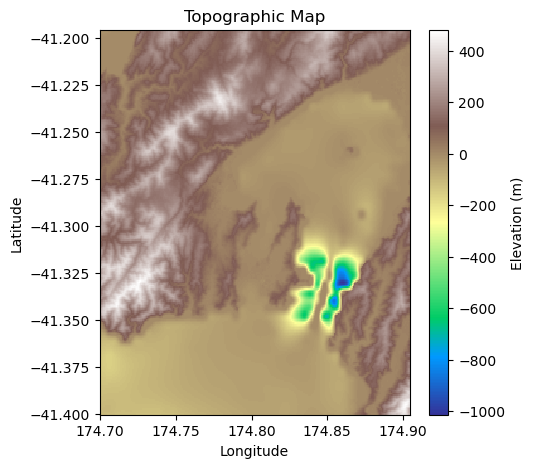

<Figure size 640x480 with 0 Axes>

In [5]:
# Provide the path to your NetCDF file
nc_file_path = './Geometry/NZ_gebco_03s.grd'

# Call the function to plot the surface rupture intensity
plot_topographic_data(nc_file_path)
plt.savefig('NZtopo_v1.png',dpi=300)

In [4]:
def plot_topographic_data(filename, figsize=(10, 6), cmap="terrain"):
    """
    Plots topographic data from a NetCDF file.

    Args:
        filename (str): Path to the NetCDF file.
        figsize (tuple, optional): Figure size. Defaults to (10, 6).
        cmap (str, optional): Colormap for elevation. Defaults to "terrain".
    """

    # Open the NetCDF file
    dataset = netCDF4.Dataset(filename)

    # Extract the data
    longitude = dataset.variables["lon"][:]
    latitude = dataset.variables["lat"][:]
    elevation = dataset.variables["z"][:]

    # Create the plot
    figsize=(5,5)
    plt.figure(figsize=figsize)

    # Use a colormap to visualize elevation
    plt.pcolormesh(longitude, latitude, elevation, cmap=cmap)

    # Add coastlines and other map features (optional)
    # map = Basemap(projection="utm", resolution="l", llcrnrlon=min(longitude), llcrnrlat=min(latitude),
    #               urcrnrlon=max(longitude), urcrnrlat=max(latitude))
    # map.drawcoastlines()
    # map.drawcountries()
    # map.drawstates()

    # Add colorbar
    plt.colorbar(label="Elevation (m)")

    # Add labels and title
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Topographic Map")

    # Show the plot
    plt.show()

# Example usage:
# plot_topographic_data("your_netcdf_file.nc")  # Replace with your file path

In [7]:
# Initialize GMSH model


In [120]:
# Create curves along grid lines (ensuring closed loops)


In [9]:
# surface_loops.remove([489, 490, 489, 490])
# surface_loops
# gmsh.model.occ.addSurfaceFilling?

In [8]:
# Create a surface from the points


In [ ]:
# Extrude the surface to create a volumetric region
gmsh.model.geo.extrude([(2, surface)], 0, 0, -20e3)  # Extrude by 20 km in the z-direction


# Set refined mesh size on the surface
gmsh.model.mesh.setSize(surface, surf_size)  # Adjust desired refinement size


# Define fault parameters (replace with your actual values)
strike = 45  # Angle between true north and strike line in degrees
dip = 60  # Angle between horizontal plane and fault plane in degrees
dip_direction = 90  # Direction the fault dips towards in degrees
depth = -100  # Depth of fault plane below surface in meters
length = 10000  # Length of fault plane in meters
width = 2000  # Width of fault plane in meters

# Create the fault plane
fault_plane = gmsh.model.geo.addPlane(
    length, width, origin=(xyz_city[0], xyz_city[1], -depth), 
    rotate_z=(strike + 90), rotate_x=-dip
)

# Intersect fault plane with surface
intersection_points = gmsh.model.geo.intersect([(2, fault_plane), (2, surface)])

# Create rupture trace line
rupture_trace = gmsh.model.geo.addLine(intersection_points)

# Refine mesh near the fault

zone_size = 500.0   # Width of refined zone around rupture trace in meters
gmsh.model.mesh.setSize(rupture_trace, flt_size)  # Set desired refinement size on fault

# Create distance field from rupture trace
fault_field = gmsh.model.mesh.field.add("Distance")
gmsh.model.mesh.field.setNumber(fault_field, 2)  # 2 for distance from rupture trace

# Combine distance fields
combined_field = gmsh.model.mesh.field.add("Composite")
gmsh.model.mesh.field.setNumbers(combined_field, [field, fault_field])



# Extrude the surface (... same as before ...)

# Set coarser mesh size away from the surface
field = gmsh.model.mesh.field.add("Distance")
gmsh.model.mesh.field.setNumber(field, 2)  # 2 for distance from surface
gmsh.model.mesh.field.setBackgroundMesh(field)  # Apply to background mesh

# Create a mesh size variation function
f = gmsh.model.mesh.field.add("MathEval")
gmsh.model.mesh.field.setString(f, "F", "0.5*(1 + cos(4*pi*Distance/Extrude.Size[0]))")  # Adjust function as needed

# Combine the distance field and function to create a smooth transition
combined_field = gmsh.model.mesh.field.add("Composite")
gmsh.model.mesh.field.setNumbers(combined_field, [field, f])

# Apply the combined field to the mesh
gmsh.model.mesh.field.setAsBackgroundMesh(combined_field)


# Generate a tetrahedral mesh
gmsh.model.mesh.generate(2)  # 3 for 3D mesh

# Write the mesh to a file
gmsh.write("test_flt_topo_trace.msh")



In [135]:
# Finalize GMSH
# gmsh.finalize()

# Appendix 1. Exercise for Python

In [7]:
a=(1,2,3)
sum(a)

6

In [8]:
x="125,000"

In [10]:
x.isdigit()

False

In [14]:
x={1,2,3}
y={2,3,4}

In [24]:
(x|y) - (x & y)

{1, 4}

In [25]:
x in y


False

In [32]:
sum([i for i in range(10) if i%2!=0])

25

In [36]:
import numpy
numpy.random.random((5,2,3))

array([[[0.09242112, 0.6884728 , 0.9846461 ],
        [0.99294198, 0.86732648, 0.55460549]],

       [[0.94602083, 0.12259691, 0.64803602],
        [0.31943539, 0.39330027, 0.16280594]],

       [[0.61625272, 0.74035743, 0.23296456],
        [0.76628737, 0.28174574, 0.90219451]],

       [[0.05175685, 0.95036998, 0.70482993],
        [0.51873199, 0.63592824, 0.35298099]],

       [[0.51052023, 0.29707985, 0.28125666],
        [0.0455183 , 0.08399731, 0.1112479 ]]])

In [59]:
# numpy.random.normal?


In [58]:
523/4

130.75

In [3]:
 226 *36

8136